In [13]:
### Library Import Initialization
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# Function Import
import sys
sys.path.append('/Users/mburley/MonteCarlo/MonteCarlo')
from MC_Functions import import_stock_data, daily_returns

[*********************100%%**********************]  1 of 1 completed


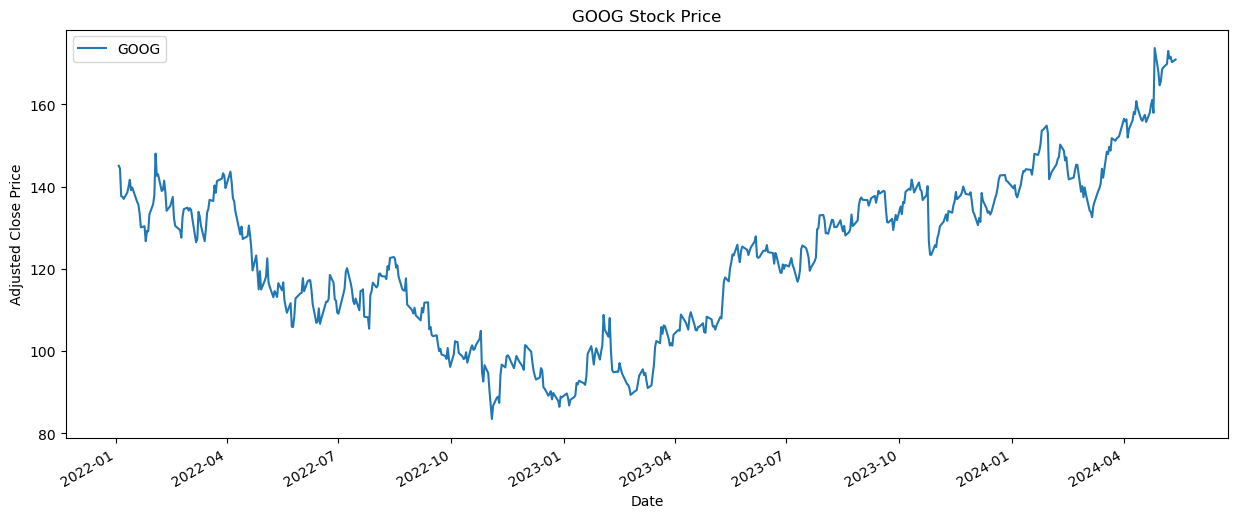

In [12]:
### Function to Import Stock Tickers
# Import Stock Data
tickers = 'GOOG'
start_date = '2022-01-01'
stock_data = import_stock_data(tickers, start_date)

# Plot
stock_data.plot(figsize=(15, 6))
plt.title(f'{tickers} Stock Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

[[170.8999939  170.8999939  170.8999939  ... 170.8999939  170.8999939
  170.8999939 ]
 [166.12419011 174.57746121 170.95549374 ... 169.48969946 171.73518351
  174.92211028]
 [170.17238745 174.55519371 167.95288047 ... 173.42487249 173.02065152
  175.28905542]
 ...
 [189.46025913 166.94856753 172.92385616 ... 145.11146861 199.9251796
  162.29508723]
 [189.16388799 163.79664824 176.37721206 ... 144.0726552  201.26890383
  164.51739791]
 [188.73221706 166.46595956 175.61567843 ... 144.50003985 199.723043
  163.17356953]]


<function matplotlib.pyplot.show(close=None, block=None)>

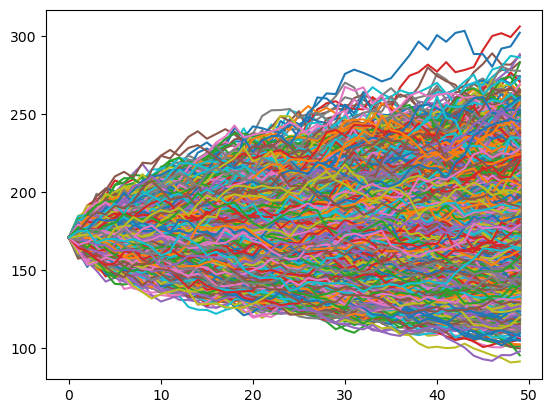

In [36]:
### Function Calls to Compute Daily Log Returns (Brownian Motion) and Generate Paths 
# Compute Daily Returns
days = 50           # Projecting out 50 days
trials = 10000      # Total trials
daily_rets = daily_returns(stock_data, days, trials, return_type = 'log')
#daily_rets

# Generate Price Paths
def price_paths(data, daily_returns):
    # Initialize array with the same shape as daily_returns but filled with zeros
    price_paths = np.zeros_like(daily_returns)
    # Set initial value of price paths to the last value in the stock prices df
    price_paths[0] = data.iloc[-1]

    # Loop over the price paths array and compute the price at each time step (t) based on the previous price (price_paths[t-1]) and the 
    # corresponding daily return (daily_returns[t])
    for t in range(1, days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]

    return price_paths

# Call and Plot each of the 10000 price paths over the 50 day span
paths = price_paths(stock_data, daily_rets)
print(paths)
plt.plot(paths)
plt.show


In [34]:
### Calculate Payoff for each Path
def payoffs(K, price_paths, option_type):
    """
    Calculate the payoffs for each path in a list of price paths
    based on the option type (call or put).
    """
    num_paths = len(price_paths)
    num_steps = len(price_paths[0])  # Assuming all paths have the same number of steps
    payoffs_matrix = np.zeros((num_paths, num_steps))  # Initialize an array to store payoffs

    for i in range(num_paths):
        for j in range(num_steps):
            if option_type == 'call':
                payoff = max(0, price_paths[i][j] - K)
            elif option_type == 'put':
                payoff = max(0, K - price_paths[i][j])
            else:
                raise ValueError("Invalid option type. Use 'call' or 'put'.")

            payoffs_matrix[i][j] = payoff  # Assign calculated payoff to the matrix

    return payoffs_matrix

# Function Call - For N simulated paths and T time steps, your array of option values would be of size N×T
K = 174
payoff_matrix = payoffs(K, paths, option_type = 'call')
payoff_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.4321443 , 26.71788506,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.24153828, 25.65538148,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.96467597, 27.95136031,  0.        , ...,  0.        ,
         0.        ,  0.        ]])